# Import Libraries

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from skimage import io, img_as_float
import cv2
from skimage import filters
import os
import glob
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# Load the Dataset

In [2]:
import kagglehub
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

In [3]:
train = path + "/chest_xray/train"
test = path + "/chest_xray/test"
val = path + "/chest_xray/val"

In [4]:
train_normal = os.path.join(train, "NORMAL")
train_pneumonia = os.path.join(train, "PNEUMONIA")
test_normal = os.path.join(test, "NORMAL")
test_pneumonia = os.path.join(test, "PNEUMONIA")
val_normal = os.path.join(val, "NORMAL")
val_pneumonia = os.path.join(val, "PNEUMONIA")

# Count and Compare Images in Each Folder

In [5]:
for folder in [train_normal, train_pneumonia, test_normal, test_pneumonia, val_normal, val_pneumonia]:
    print(f"{folder.split('/')[-2:]}:", len(os.listdir(folder)))

['train', 'NORMAL']: 1341
['train', 'PNEUMONIA']: 3875
['test', 'NORMAL']: 234
['test', 'PNEUMONIA']: 390
['val', 'NORMAL']: 8
['val', 'PNEUMONIA']: 8


In [6]:
normal_count = len(os.listdir(train_normal)) + len(os.listdir(test_normal)) + len(os.listdir(val_normal))
pneumonia_count = len(os.listdir(train_pneumonia)) + len(os.listdir(test_pneumonia)) + len(os.listdir(val_pneumonia))

print(f"Total Normal images: {normal_count}")
print(f"Total Pneumonia images: {pneumonia_count}")

Total Normal images: 1583
Total Pneumonia images: 4273


# Visualize the Dataset

In [7]:
def vis(folder):
  for img in os.listdir(folder)[:3]:
    img_path = os.path.join(folder, img)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()


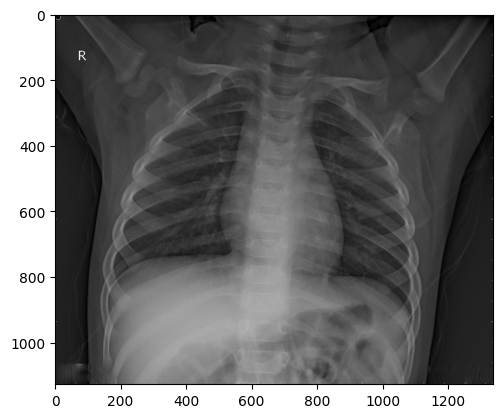

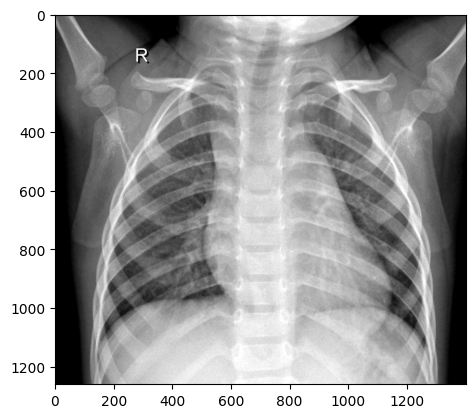

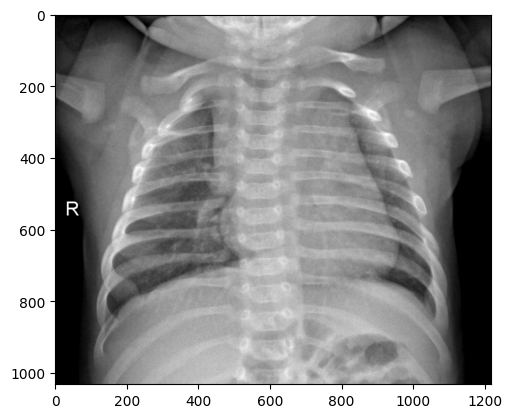

In [8]:
vis(train_normal)

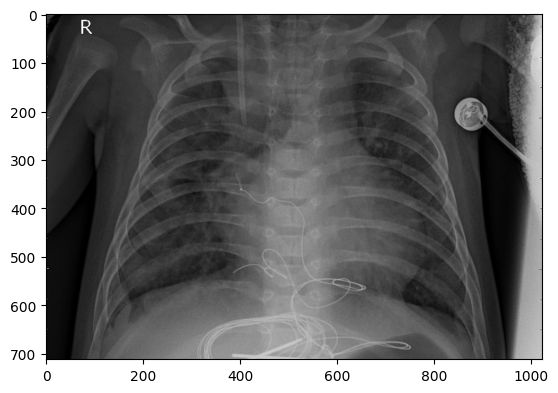

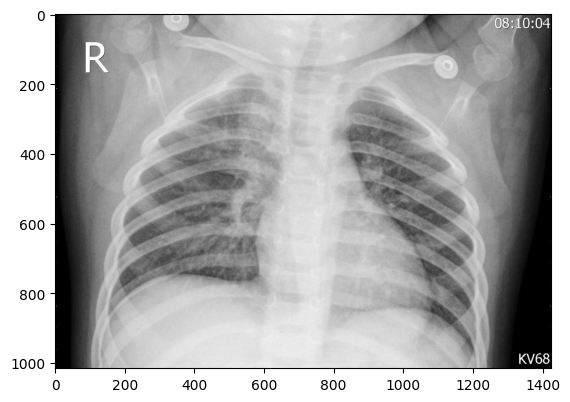

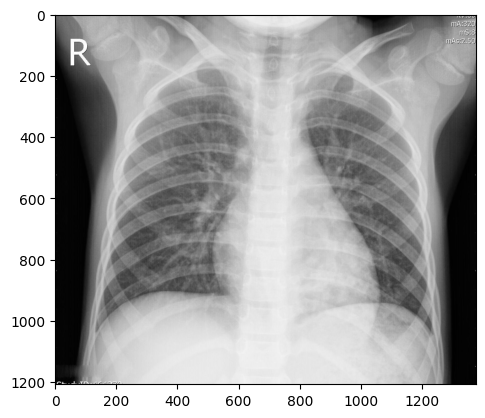

In [9]:
vis(train_pneumonia)

# Check Image Sizes and Shapes

In [10]:
image_paths = glob.glob(os.path.join(train_normal, '*.jpeg'))[:3]+ \
                glob.glob(os.path.join(train_pneumonia, '*.jpeg'))[:3]

In [11]:
image_sizes = []
for img_path in image_paths:
  with Image.open(img_path)as img:
    size = img.size
    image_sizes.append(size)
    print(f"Image: {os.path.basename(img_path)}, Dimensions: {size}")

Image: NORMAL2-IM-0771-0001.jpeg, Dimensions: (1336, 1128)
Image: NORMAL2-IM-1294-0001-0002.jpeg, Dimensions: (1400, 1260)
Image: IM-0675-0001.jpeg, Dimensions: (1218, 1032)
Image: person1180_virus_2010.jpeg, Dimensions: (1024, 712)
Image: person1230_virus_2081.jpeg, Dimensions: (1424, 1016)
Image: person1513_virus_2632.jpeg, Dimensions: (1376, 1208)


In [12]:
all_same_size = len(set(image_sizes)) == 1

if all_same_size:
    print("\nAll loaded images have the same dimensions.")
else:
    print("\nThe loaded images have different dimensions.")


The loaded images have different dimensions.


# Resize and Normalize Images

In [13]:
IMAGE_SIZE = (150, 150)

def preprocess_image(image_path, target_size=IMAGE_SIZE):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = img_array / 255.0
    return img_array

sample_image_path = glob.glob(os.path.join(train_normal, '*.jpeg'))[0]
processed_image = preprocess_image(sample_image_path)

print("Original image shape:", np.array(Image.open(sample_image_path)).shape)
print("Processed image shape:", processed_image.shape)
print("Processed image pixel range:", processed_image.min(), processed_image.max())

Original image shape: (1128, 1336)
Processed image shape: (150, 150, 3)
Processed image pixel range: 0.0 0.6862745098039216


# Convert Images into Arrays

In [14]:
def create_dataset(data_dir):
    images = []
    labels = []
    for label_folder in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_folder)
        if os.path.isdir(label_path):
            for image_file in tqdm(os.listdir(label_path), desc=f"Processing {label_folder}"):
                image_path = os.path.join(label_path, image_file)
                img_array = preprocess_image(image_path)
                images.append(img_array)
                labels.append(label_folder)

    return np.array(images), np.array(labels)

In [15]:
print("Creating training dataset...")
train_images, train_labels = create_dataset(train)
print("Creating testing dataset...")
test_images, test_labels = create_dataset(test)
print("Creating validation dataset...")
val_images, val_labels = create_dataset(val)

print("\nTraining images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Testing images shape:", test_images.shape)
print("Testing labels shape:", test_labels.shape)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)

Creating training dataset...


Processing NORMAL: 100%|██████████| 1341/1341 [01:16<00:00, 17.62it/s]


Creating testing dataset...


Processing NORMAL: 100%|██████████| 234/234 [00:11<00:00, 20.38it/s]


Creating validation dataset...


Processing NORMAL: 100%|██████████| 8/8 [00:00<00:00, 25.54it/s]


Training images shape: (5216, 150, 150, 3)
Training labels shape: (5216,)
Testing images shape: (624, 150, 150, 3)
Testing labels shape: (624,)
Validation images shape: (16, 150, 150, 3)
Validation labels shape: (16,)
